In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [2]:
from functools import partial
from scipy.misc import central_diff_weights

def richardson(f, x, n, h):
    """
    Richardson's Extrapolation
    """
    d = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        d[i, 0] = 0.5 * (f(y=x + h) - f(y=x - h)) / h
        p4 = 1  # values of 4^j
        for j in range(1, i + 1):
            p4 = 4 * p4
            d[i, j] = d[i, j-1] + (d[i, j-1] - d[i-1,j-1]) / ( p4 - 1 )
        h = 0.5 * h
    return d[n, n]

def n_order_scheme(f, x, h, n, *args, **kwargs):
    """
    Used in experiments
    """
    weights = central_diff_weights(n)
    grad_f = 0
    for i, j in enumerate(np.arange(- (n // 2), 1 + n // 2)):
        grad_f += weights[i] * f(y=x + j * h)
    return grad_f / h

def partial_function(f, x, i, y):
    return f((x[:i] + [y] + x[i + 1:]))

def compute_gradient_of_vector_function(f, x, n, h, ):
    dim = len(x)
    partial_derivatives = []
    number_of_evaluations = 0
    for i in range(dim):
        number_of_evaluations += 4 # n * 2
        partial_derivatives.append(
            n_order_scheme(partial(partial_function, f=f, x=x, i=i), x[i], n=n, h=h)
        )
    return partial_derivatives, number_of_evaluations

In [3]:
def rosenbrock(X):
    x = X[0]
    y = X[1]
    a = 1. - x
    b = y - x*x
    return a*a + b*b*100.

compute_gradient_of_vector_function(f=rosenbrock, x=[0.1, 0.], n=7, h=0.1)

([-1.399999999999998, -2.0], 8)

In [4]:
import os
import sys
sys.path.append("..")

In [5]:
from model import YModel, OptLoss
from utils import sample_noise, iterate_minibatches, generate_data
from pyro import distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [6]:
y_sampler = YModel()

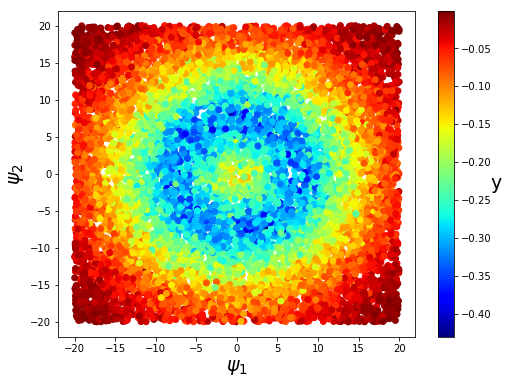

In [7]:
mu = dist.Uniform(-20, 20).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 100]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

y = y_sampler.condition_sample()
c = OptLoss.SigmoidLoss(y, 5, 10).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(mu[:,0], mu[:, 1], c=c, cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.show()

In [8]:
# !pip install git+https://github.com/mariogeiger/hessian.git

In [9]:
from hessian import hessian as hessian_calc

In [10]:
NUM_RUNS_PER_CALL = 400
def optimized_function(mu, N=NUM_RUNS_PER_CALL):
    mu = torch.tensor(mu).float().repeat(1, 2)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu), N]))
    y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

    y = y_sampler.condition_sample()
    return OptLoss.SigmoidLoss(y, 5, 10).mean().item()

In [11]:
def optimized_function_grad_hessian(mu, N=NUM_RUNS_PER_CALL):
    mu = torch.tensor(mu, requires_grad=True, dtype=torch.float)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu.view(1, 2)), N]))
    y_sampler.make_condition_sample({'mu': mu.view(1, 2), 'X': x_r})

    y = y_sampler.condition_sample()
    L = OptLoss.SigmoidLoss(y, 5, 10).mean()
    h = hessian_calc(L, mu)
    L.backward()
    
    return mu.grad, h

In [12]:
def rotate_vector(x, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    return R.dot(x)

## Biased gradients

Generally, our numerical derivative is a function of noisy inputs. We are making two assumptions: noise terms are independent(which might not be true) and mathematical expectation of noise is zero.

$$f_x' \approx \frac{f(x + h + \epsilon_1, y + \epsilon_2) - f(x + \epsilon_3, y + \epsilon_4)}{h}, ~~~\epsilon_{\{1,2,3, 4\}} \sim p(\epsilon), ~~\mathrm{E}~\epsilon = 0$$

Let's take one term:

$$f(x + h + \epsilon_1, y + \epsilon_2 = f(x + h, y) + \vec{\epsilon} \nabla f(x + h, y) + \vec{\epsilon}^{T} \nabla^2 f(x + h, y) \vec{\epsilon} + o(|| \epsilon ||^3)$$


Mathematical expectation over noise:

$$\mathrm{E} f(x + h + \epsilon_1, y + \epsilon_2) = f(x + h, y) + \mathrm{tr} \left( \mathrm{E}(\epsilon \epsilon^T) \nabla^2 f \right)  + \dots $$

In [14]:
mu_init = np.array([-15., -15.])

def investigation_of_biased_grads(mu):
    lr = 0.1
    mus = []
    grads = []
    grads_true = []
    hessians_true = []
    grad = np.zeros(2)
    momentum = 0.99
    for i in (range(100)):
        grad_new, num_evaluations = compute_gradient_of_vector_function(optimized_function, mu.tolist(), n=7, h=.5)
        mu_grad, mu_hessian = optimized_function_grad_hessian(mu)
        grad = np.array(grad_new) # momentum * grad + (1 - momentum) * 
        mu = mu - lr * grad

        grads.append(grad)
        grads_true.append(mu_grad.detach().cpu().numpy())
        hessians_true.append(mu_hessian.detach().cpu().numpy())

        mus.append(mu)

    grads = np.array(grads)
    grads_true = np.array(grads_true)
    hessians_true = np.array(hessians_true)
    
    return grads, grads_true, hessians_true

### Investigation of biased grads

1. Estimate gradients multiple times at some point
2. Fit bias of gradient in y-dimension as linear function of bias in x-dimension: bias $\nabla_y f  = k \nabla_x + c$
3. Calculate eigenvector of hessian
4. visualize $\arctan(\mathrm{eigenvector})$ and $\arctan(k)$

In [15]:
from sklearn.linear_model import TheilSenRegressor
grad_rotations = []
grad_x_median_shift = []
grad_y_median_shift = []
hessians_all = []
hessian_eigen_vector_directions = []
hessian_traces = []

for angle in tqdm(np.linspace(0, 90, 180)):
    grads, grads_true, hessians_true = investigation_of_biased_grads(rotate_vector(mu_init, angle))
    eival, eivec = np.linalg.eig(hessians_true)
    linreg = TheilSenRegressor().fit((grads[:, 1] - grads_true[:, 1]).reshape(-1, 1), grads[:, 0] - grads_true[:, 0])
    
    grad_x_median_shift.append(np.median(grads[:, 0] - grads_true[:, 0]))
    grad_y_median_shift.append(np.median(grads[:, 1] - grads_true[:, 1]))


    grad_rotation = np.arctan(linreg.coef_[0])
    grad_rotations.append(grad_rotation)
    
    hessian_eigen_vector_directions.append(np.median(np.arctan(eivec[:, 1, 0] / eivec[:, 0, 0])))
    hessian_traces.append(np.median(hessians_true[:, 0, 0] + hessians_true[:, 1, 1]))
    hessians_all.append(np.median(hessians_true, axis=0))

100%|██████████| 180/180 [03:23<00:00,  1.12s/it]


In [16]:
hessians_all = np.concatenate(hessians_all)

In [17]:
import matplotlib

# Customize††matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
matplotlib.rcParams['pdf.fonttype'] = 3
matplotlib.rcParams['ps.fonttype'] = 3

Text(0, 0.5, 'Direction(arctan2) of first eigenvalue of hessian')

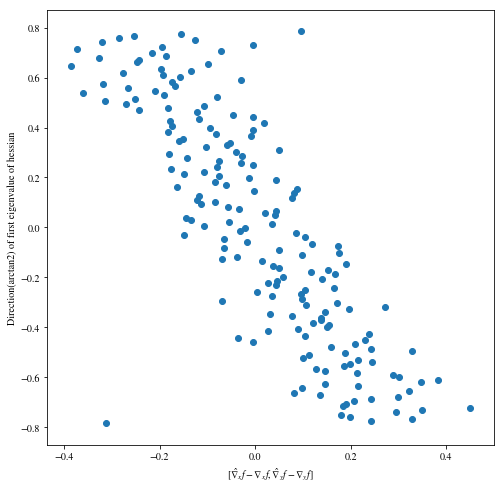

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_rotations, hessian_eigen_vector_directions)
plt.xlabel('$ [ \hat{\\nabla}_x f -  \\nabla_x f, \hat{\\nabla}_y f -  \\nabla_y f ] $')
plt.ylabel('Direction(arctan2) of first eigenvalue of hessian')

Text(0, 0.5, 'hessian trace')

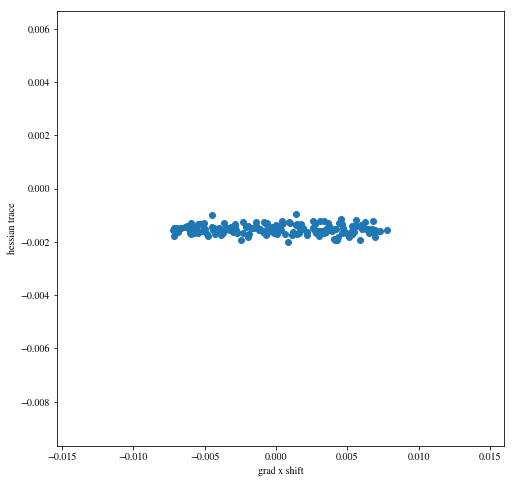

In [19]:
plt.figure(figsize=(8, 8))
hessian_traces_med = list(map(np.median, hessian_traces))
plt.scatter(grad_x_median_shift, hessian_traces_med)
plt.xlabel('grad x shift')
plt.ylabel('hessian trace')

In [20]:
hessians_all = hessians_all.reshape(-1, 2, 2)

Text(0, 0.5, 'hessian xy')

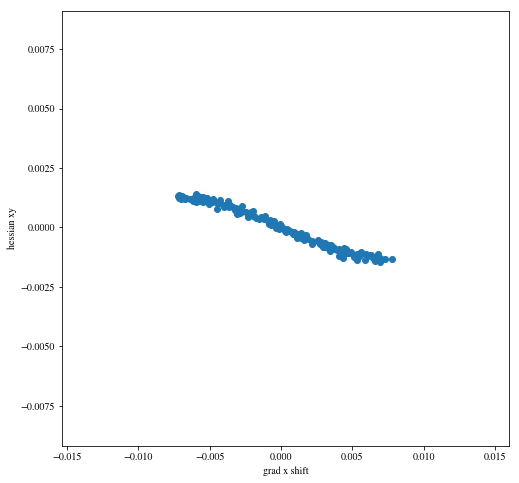

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_x_median_shift, hessians_all[:, 0, 1])
plt.xlabel('grad x shift')
plt.ylabel('hessian xy')

Text(0, 0.5, 'hessian xy')

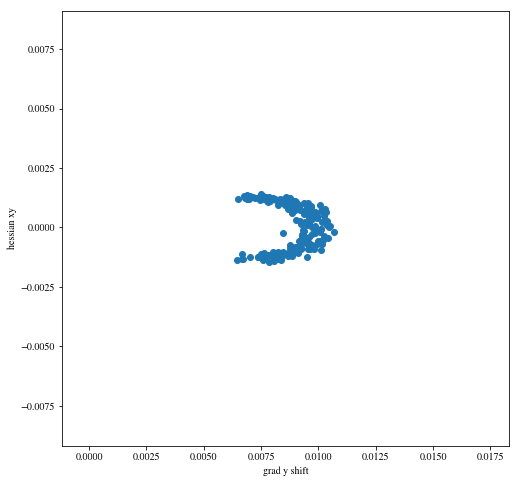

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_y_median_shift, hessians_all[:, 0, 1])
plt.xlabel('grad y shift')
plt.ylabel('hessian xy')

NameError: name 'mus' is not defined

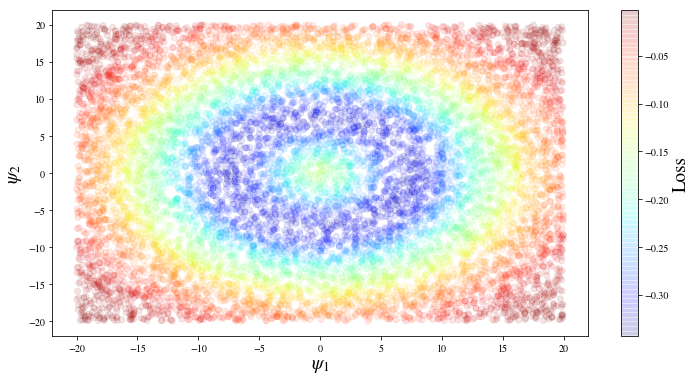

In [28]:
plt.figure(figsize=(12, 6))

mu = dist.Uniform(-20, 20).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

plt.scatter(mu[:, 0], mu[:, 1], c=rs,  cmap=my_cmap, alpha=0.1)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)


# for index, mu_path in enumerate(opt_mu):
# plt.scatter(mus[0, 0], mus[0, 1], marker='^', s=400)
# plt.scatter(mus[::10, 0], mus[::10, 1], marker='+', s=200)
plt.grid()
plt.grid()

In [ ]:
mus